### 1.按公司文件分开训练模型

GPU 可用，使用 GPU 加速
Epoch 1/100, Validation Loss: 0.03315862454473972
Epoch 2/100, Validation Loss: 0.0058372896164655685
Epoch 3/100, Validation Loss: 0.014194611925631762
Epoch 4/100, Validation Loss: 0.02793882042169571
Epoch 5/100, Validation Loss: 0.020476049277931452
Epoch 6/100, Validation Loss: 0.00744011695496738
Epoch 7/100, Validation Loss: 0.005713578080758452
Epoch 8/100, Validation Loss: 0.005114856408908963
Epoch 9/100, Validation Loss: 0.007065659388899803
Epoch 10/100, Validation Loss: 0.0050346506759524345
Epoch 11/100, Validation Loss: 0.004665139829739928
Epoch 12/100, Validation Loss: 0.005154391285032034
Epoch 13/100, Validation Loss: 0.004686672938987613
Epoch 14/100, Validation Loss: 0.003717521147336811
Epoch 15/100, Validation Loss: 0.005023466655984521
Epoch 16/100, Validation Loss: 0.003945176140405238
Epoch 17/100, Validation Loss: 0.004662536317482591
Epoch 18/100, Validation Loss: 0.005387273617088795
Epoch 19/100, Validation Loss: 0.003877746989019215
Epoch

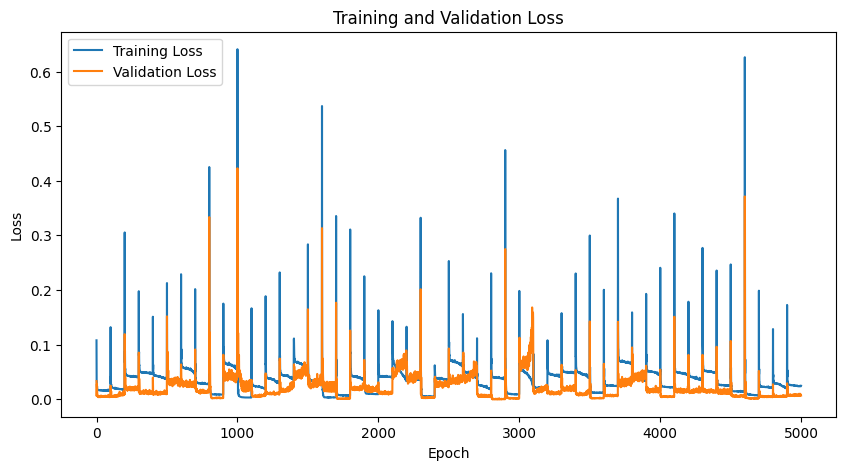

000001.SZ_平安银行_all2.xlsx: MAE=0.04773522540926933, MSE=0.0050983792170882225, R2=-0.026520360755876382
000002.SZ_万科A_all2.xlsx: MAE=0.702603280544281, MSE=0.5482478141784668, R2=-9.559899223056778
000063.SZ_中兴通讯_all2.xlsx: MAE=0.07683490961790085, MSE=0.009019832126796246, R2=-0.01578982597224443
000100.SZ_TCL科技_all2.xlsx: MAE=0.08929962664842606, MSE=0.018137456849217415, R2=-0.0007340911295290464
000157.SZ_中联重科_all2.xlsx: MAE=0.08608690649271011, MSE=0.015923932194709778, R2=0.0725943170726614
000166.SZ_申万宏源_all2.xlsx: MAE=0.09700241684913635, MSE=0.017403891310095787, R2=-0.038987842431772224
000301.SZ_东方盛虹_all2.xlsx: MAE=0.14659182727336884, MSE=0.029954591765999794, R2=-0.8648731708448789
000333.SZ_美的集团_all2.xlsx: MAE=0.11908147484064102, MSE=0.025226235389709473, R2=-0.3162436124343475
000338.SZ_潍柴动力_all2.xlsx: MAE=0.030992498621344566, MSE=0.001743094064295292, R2=-0.6603634464445955
000408.SZ_藏格矿业_all2.xlsx: MAE=0.19555878639221191, MSE=0.06602054089307785, R2=-3.12737421764390

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device):
    """
    训练和评估模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param test_loader: 测试数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表，测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return train_losses, val_losses, mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 100
    learning_rate = 0.001
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    hidden_size = 50
    num_layers = 2
    output_size = 1


    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")


    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []


    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            train_dataset = TensorDataset(train_x, train_y)
            val_dataset = TensorDataset(val_x, val_y)
            test_dataset = TensorDataset(test_x, test_y)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32)
            model = BiGRUModel(input_size, hidden_size, num_layers, output_size).to(device)
            train_losses, val_losses, mae, mse, r2 = train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device)
            all_train_losses.extend(train_losses)
            all_val_losses.extend(val_losses)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)


    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


    # 输出每个公司的指标结果
    for i, file in enumerate(os.listdir(folder_path)):
        if file.endswith('.xlsx'):
            print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')


class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiGRUModel, self).__init__()
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)


    def forward(self, x):
        out, _ = self.bigru(x)
        out = self.fc(out[:, -1, :])
        return out


if __name__ == "__main__":
    main()

### 2.合在一块训练

GPU 可用，使用 GPU 加速
Epoch 1/600, Validation Loss: 0.02985918734380057
Epoch 2/600, Validation Loss: 0.028152764341990714
Epoch 3/600, Validation Loss: 0.028004738528438856
Epoch 4/600, Validation Loss: 0.02498667708165209
Epoch 5/600, Validation Loss: 0.025522490294361617
Epoch 6/600, Validation Loss: 0.02473323813206713
Epoch 7/600, Validation Loss: 0.024190396752575755
Epoch 8/600, Validation Loss: 0.023829429187405278
Epoch 9/600, Validation Loss: 0.02389529424811333
Epoch 10/600, Validation Loss: 0.022821996807002684
Epoch 11/600, Validation Loss: 0.02569371119508861
Epoch 12/600, Validation Loss: 0.025129820639923424
Epoch 13/600, Validation Loss: 0.02403286287665997
Epoch 14/600, Validation Loss: 0.02720895315140066
Epoch 15/600, Validation Loss: 0.02395779482075866
Epoch 16/600, Validation Loss: 0.021818401606779704
Epoch 17/600, Validation Loss: 0.02226703789767245
Epoch 18/600, Validation Loss: 0.02166375721162054
Epoch 19/600, Validation Loss: 0.022303682896243016
Epoch 20/600, 

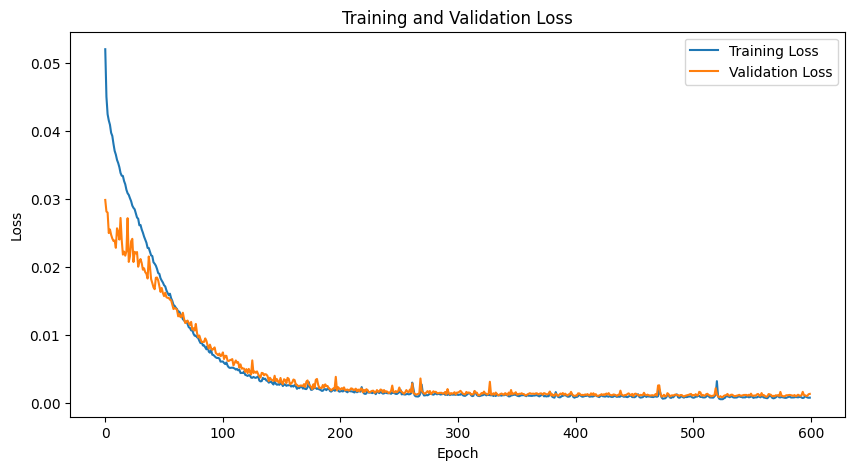

000001.SZ_平安银行_all2.xlsx: MAE=0.10304541140794754, MSE=0.016498610377311707, R2=-2.3218712850055883
000002.SZ_万科A_all2.xlsx: MAE=0.2376871556043625, MSE=0.09278565645217896, R2=-0.7871611844639979
000063.SZ_中兴通讯_all2.xlsx: MAE=0.10284066200256348, MSE=0.020113179460167885, R2=-1.2650937443898056
000100.SZ_TCL科技_all2.xlsx: MAE=0.11039310693740845, MSE=0.026054413989186287, R2=-0.43755212441454705
000157.SZ_中联重科_all2.xlsx: MAE=0.10817494988441467, MSE=0.01911824382841587, R2=-0.11344147225769774
000166.SZ_申万宏源_all2.xlsx: MAE=0.14808733761310577, MSE=0.03181701526045799, R2=-0.8994308710467591
000301.SZ_东方盛虹_all2.xlsx: MAE=0.11423686891794205, MSE=0.022365892305970192, R2=-0.392426041877189
000333.SZ_美的集团_all2.xlsx: MAE=0.1399877518415451, MSE=0.03675981983542442, R2=-0.918037963538743
000338.SZ_潍柴动力_all2.xlsx: MAE=0.13085423409938812, MSE=0.025976935401558876, R2=-23.744023328166097
000408.SZ_藏格矿业_all2.xlsx: MAE=0.15902425348758698, MSE=0.047144144773483276, R2=-1.9472875875348965
000425

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    # 将训练集和验证集数据合并
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 600
    learning_rate = 0.001
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    hidden_size = 50
    num_layers = 2
    output_size = 1

    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    # 存储所有公司的训练集、验证集和测试集数据
    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)  # 1.先读取文件
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  # 2.滑动窗口造样本
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  # 针对时间窗口，尽可能使用所有数据序列
            val_y = sequences_y[train_size:train_size + val_size]
            # test_x = sequences_x[train_size + val_size:]
            # test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            # all_test_x.extend(test_x)#@修改为列表中的列表
            # all_test_y.extend(test_y)#@修改为列表中的列表

    # 合并所有公司的训练集和验证集数据
    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 3.混合样本
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = BiGRUModel(input_size, hidden_size, num_layers, output_size).to(device)
    # 1.训练
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    # 2.验证mae,mse
    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows) #滑动窗口
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            test_dataset = TensorDataset(test_x, test_y)
            test_loader = DataLoader(test_dataset, batch_size=32)
            mae, mse, r2 = evaluate_model(model, test_loader, device)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # 输出每个公司的指标结果
    for i, file in enumerate(file_list):
        print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')

    # 存储模型
    model_save_path = 'best_lstm_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiGRUModel, self).__init__()
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)


    def forward(self, x):
        out, _ = self.bigru(x)
        out = self.fc(out[:, -1, :])
        return out


if __name__ == "__main__":
    main()

### 3.优化r^2结果，增加预测相关性

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled, scaler_y


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=100, gamma=0.1)  # 学习率调度器
    train_losses = []
    val_losses = []
    # 将训练集和验证集数据合并
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        scheduler.step()  # 更新学习率
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 800  # 增加训练轮数
    learning_rate = 0.001
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    hidden_size = 64  # 增加隐藏层大小
    num_layers = 2
    output_size = 1

    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    # 存储所有公司的训练集、验证集和测试集数据
    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []
    all_scaler_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled, scaler_y = load_and_preprocess_data(file_path)  # 1.先读取文件
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  # 2.滑动窗口造样本
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  # 针对时间窗口，尽可能使用所有数据序列
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)
            all_scaler_y.append(scaler_y)

    # 合并所有公司的训练集和验证集数据
    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 3.混合样本
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = BiGRUModel(input_size, hidden_size, num_layers, output_size).to(device)
    # 1.训练
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    # 2.验证mae,mse
    for i, file in enumerate(file_list):
        test_x = all_test_x[i]
        test_y = all_test_y[i]
        test_dataset = TensorDataset(test_x, test_y)
        test_loader = DataLoader(test_dataset, batch_size=32)
        mae, mse, r2 = evaluate_model(model, test_loader, device)
        all_mae.append(mae)
        all_mse.append(mse)
        all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # 输出每个公司的指标结果
    for i, file in enumerate(file_list):
        print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')

    # 存储模型
    model_save_path = 'best_bigru_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiGRUModel, self).__init__()
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)  # 添加 Dropout 层
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.bigru(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


if __name__ == "__main__":
    main()